# **Дипломный проект выпускника курса Data Science Бычкова Александра**

**Задача: разработать сервис, который будет предсказывать стоимость домов, основываясь на истории предложений.**

# DATA

Загружаем данные и библиотеки, необходимые для построения модели

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# подгрузим еще библиотеки, которые могут понадобится для EDA
from itertools import combinations
from scipy.stats import ttest_ind
import re
from datetime import datetime, timedelta
from sklearn.preprocessing import PolynomialFeatures
import pandas_profiling
from ast import literal_eval as le
from tqdm import tqdm
tqdm.pandas()
import time


from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
label_encoder = LabelEncoder()

# Загружаем инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/data-diplom/data_diplom.csv
/kaggle/input/diploma/data.csv
/kaggle/input/crimese/city_crime.xlsx


In [2]:
# фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import time
import datetime
import requests as r
import json
from bs4 import BeautifulSoup
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
import pandas_profiling
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor  
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.base import clone

In [4]:
DATA  = '../input/diploma/'

In [5]:
df = pd.read_csv(DATA+'data.csv')

# EDA&FE

In [6]:
df.info()
# первичный просмотр позволяет сделать вывод, что данные достаточно сырые,
# тем не менее, объема данных должно хватить для построения модели.
# датасет содержит 18 признаков, ни один из которых не числовой.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [7]:
# для удобства можно подгрузить пакет для удобной визуализации 
#!pip install pandasgui
# дальше используем команду show(df)

In [8]:
#pandas_profiling.ProfileReport(df)

**Начнем анализ каждого признака**

**target** - целевая переменная

In [9]:
#посмотрим на пустые ячейки
df['target'].isnull().value_counts()

False    374704
True       2481
Name: target, dtype: int64

In [10]:
#убираем пустые
df = df.dropna(subset=['target'])

In [11]:
#преобразовываем с помощью regex значения в int
df['target'] = df.target.replace('\D', '', regex=True).astype(int)

In [12]:
df.target.describe()

count    3.747040e+05
mean     6.447575e+05
std      1.841431e+06
min      1.000000e+00
25%      1.869900e+05
50%      3.200000e+05
75%      5.821000e+05
max      1.950000e+08
Name: target, dtype: float64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

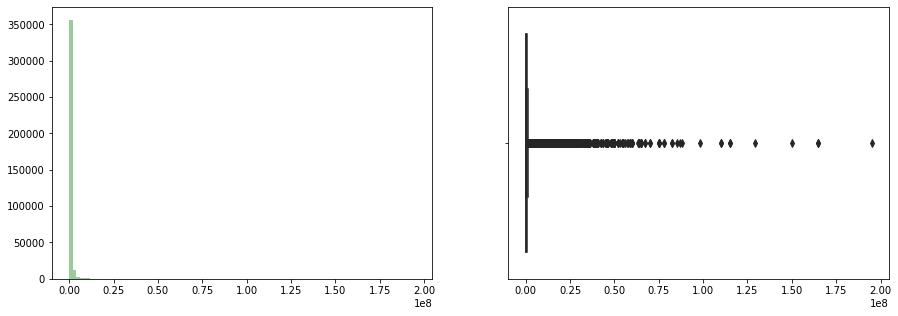

In [13]:
# построим графики распределения для этого признака
plt.figure(figsize=(15, 5))
colors = ['g', 'maroon']
plt.subplot(121)
sns.distplot(df['target'].values,
             bins=100, color=colors[0], kde=False)


plt.subplot(122)
sns.boxplot(df['target'].values, color=colors[1])
# выбросы очевидны

Графики выше указывают на большое количество выбросов.
Стоит аккуратно почистить их

In [14]:
x = df['target'].quantile(.1)
y = df['target'].quantile(.99)
print(x)
print(y)
df['target'] = df['target'].where(df['target'] >= x)
df['target'] = df['target'].where(df['target'] <= y)
df = df.dropna(subset=['target'])
print(df.target.value_counts().sum())

80000.0
5995000.0
333634


In [15]:
df.target.isna().sum()

0

In [16]:
df.target.describe()

count    3.336340e+05
mean     5.722893e+05
std      6.864015e+05
min      8.000000e+04
25%      2.250000e+05
50%      3.499900e+05
75%      6.150000e+05
max      5.995000e+06
Name: target, dtype: float64

**Status**

In [17]:
df.status.describe()

count       296706
unique         152
top       for sale
freq        139136
Name: status, dtype: object

In [18]:
df.status.unique()

array(['Active', 'for sale', nan, 'New construction', 'New', 'For sale',
       'Pending', 'P', 'Active/Contingent', ' / auction',
       'Under Contract', 'Pre-foreclosure / auction',
       'Under Contract   Showing', 'Pre-foreclosure',
       'Under Contract Backups', 'Active Under Contract', 'Foreclosed',
       'Option Pending', 'Under Contract Show', 'foreclosure', 'Auction',
       'Contingent', 'Pending   Continue To Show', 'Price Change',
       'Back on Market', 'Active Option', 'Coming soon: Nov 21.',
       'Contingent Finance And Inspection', 'Foreclosure',
       'Coming soon: Dec 4.', 'P Pending Sale', 'Coming soon: Nov 23.',
       'Active With Contingencies', 'A Active', 'Pf', 'Contingent Show',
       'Contract P', 'Contingent Take Backup', 'Backup Contract',
       'Option Contract', 'Pending Continue To Show', 'pending',
       'Pending Inspection', 'Active Option Contract', 'C',
       'Auction - Active', 'Contingent   Show', 'Pi',
       'Due Diligence Period', 'C

In [19]:
print(df.status.value_counts().head(20))

for sale                     139136
Active                        90262
For sale                      40735
New construction               5370
Pending                        4002
foreclosure                    3948
Pre-foreclosure                1816
P                              1479
Under Contract Show            1138
Pre-foreclosure / auction      1103
Under Contract   Showing        788
 / auction                      785
Active Under Contract           715
Under Contract                  676
New                             674
Price Change                    548
Contingent                      477
Auction                         415
A Active                        261
Under Contract Backups          251
Name: status, dtype: int64


In [20]:
print(df.status.isna().sum())

36928


признак Status обозначает статус объекта на момент продажи, малоинформативен.
Из 377185 записей отсутствует 39918. При этом количество уникальных значений 159.
Более 95% из них говорят о статусе - продажа. Признак не несет в себе важной нагрузки, смущает только статус Foreclosed - лишенный права выкупа, но совокупное количество данных показателей примерно равно 1%, что позволяет принять решение об удалении этого признака в целом.

**Private pool**

Признак private pool имеет 99% пропущенных значений, кроме того, мы имеем второй такой же признак PrivatePool, поэтому удалим private pool.

In [21]:
df.drop(['status', 'private pool'], axis=1, inplace=True)

**street**

In [22]:
print(df.street.describe())
print("Количество пустых значений: ", df.street.isna().sum())

count                    333632
unique                   297030
top       Address Not Disclosed
freq                        632
Name: street, dtype: object
Количество пустых значений:  2


In [23]:
print(df.street.value_counts().head(10))

Address Not Disclosed    632
Undisclosed Address      486
(undisclosed Address)    373
Address Not Available    144
Unknown Address           66
2103 E State Hwy 21       41
17030 Youngblood Rd.      38
11305 Gulf Fwy            37
9470 Lancaster Rd. SW     32
1 Palmer Dr               27
Name: street, dtype: int64


Признак street - название улицы, в идеальной модели использовать, если с помощью API запросов определить расстояние до центра в зависимости от адреса. На данный момент я не имею такой возможности. Данный признак будет удален.

**baths**

In [24]:
print(df.baths.describe())
print("Количество пустых значений: ", df.baths.isna().sum())

count      254066
unique        203
top       2 Baths
freq        48975
Name: baths, dtype: object
Количество пустых значений:  79568


In [25]:
df.baths.unique()

array(['3.5', '3 Baths', '2 Baths', '8 Baths', nan, '2', '3',
       'Bathrooms: 2', '1,750', '4 Baths', '2 ba', 'Bathrooms: 5',
       '1,000', '7 Baths', '2.0', '3.0', 'Bathrooms: 1', '4.0',
       '2.1 Baths', '2.5 Baths', '1', 'Bathrooms: 3', '4.5', '6 Baths',
       'Bathrooms: 4', '3 ba', '5', '2,500', '5.5 Baths', '1.0',
       '5 Baths', '4', '~', '2.5', '4,000', '3.5 Baths', '2,000', '3,000',
       '8.0', '1 ba', '5.0', '1,500', '7.0', '1,250', '9 Baths', '2,250',
       '6.0', '12 Baths', '5.5', '3,500', '1.5', '1.5 Baths', '2,750',
       'Bathrooms: 6', '0', '4.5 Baths', '750', '5.5+', '6', '10 Baths',
       '6 ba', 'Bathrooms: 19', '10.0', '4 ba', '12 ba', '2.5+', '8',
       '7.5+', 'Bathrooms: 10', '0 / 0', 'Sq. Ft. ', '5 ba', '4.5+',
       '-- baths', 'Bathrooms: 7', '7', '18', '3.5+', '1.5+', '11 Baths',
       '5,000', '1.75 Baths', '6.5', 'Bathrooms: 8', '10', '19 Baths',
       'Bathrooms: 9', '16 Baths', '13 Baths', '9', 'Bathrooms: 13',
       '9.0', '7 ba', '1

In [26]:
print(df.baths.value_counts().head(50))

2 Baths         48975
3 Baths         35002
2               19622
2.0             15823
4 Baths         14437
3.0             10749
3               10016
Bathrooms: 2     8745
2.5              8080
Bathrooms: 3     6527
1                5431
1.0              5246
5 Baths          5125
4.0              4485
2.5 Baths        4382
4                3514
3.5              3444
2 ba             2530
6 Baths          2394
Bathrooms: 4     2357
Bathrooms: 1     2256
1,500            2084
3 ba             1875
3.5 Baths        1785
2,000            1740
1,750            1629
3,000            1627
1.5              1586
5.0              1452
2,250            1401
1,000            1238
5                1166
1,250            1146
7 Baths          1034
4.5              1001
2,750             953
2,500             872
0                 853
Bathrooms: 5      814
~                 739
4 ba              729
6.0               641
3,500             620
1 ba              554
8 Baths           509
6         

In [27]:
# заменим пропуски в данном признаке на 0, т.к. вероятно 
# многие пропуски относятся к типу собственности land, где отсутсвуют ванные комнаты
df.baths = df.baths.fillna(float(0))

In [28]:
df.baths = df.baths.replace('Bathrooms: 2', '2')
df.baths = df.baths.replace('Bathrooms: 3', '3')
df.baths = df.baths.replace('Bathrooms: 4', '4')
df.baths = df.baths.replace('Bathrooms: 1', '1')
df.baths = df.baths.replace('Bathrooms: 5', '5')

In [29]:
print(df.baths.value_counts())

0.0                79568
2 Baths            48975
3 Baths            35002
2                  28367
3                  16543
                   ...  
116 / 116 / 116        1
14.0                   1
Bathrooms: 21          1
29 Baths               1
23.0                   1
Name: baths, Length: 199, dtype: int64


In [30]:
df.baths = df.baths.apply(lambda x: str(x))

In [31]:
df.baths = df.baths.apply(lambda x: x[:1])

In [32]:
df.baths = df.baths.replace('B', '1')
df.baths = df.baths.replace('S', '1')
df.baths = df.baths.replace('~', '0')
df.baths = df.baths.replace('-', '0')
df.baths = df.baths.replace('—', '0')
df.baths = df.baths.apply(lambda x: int(x))

<bound method Axes.barh of <AxesSubplot:>>

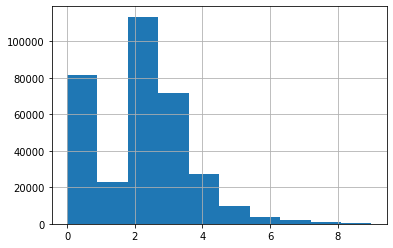

In [33]:
df.baths.hist().barh

Признак baths - количество ванных комнат, видится важным показателем в оценке стоимости. В ходе обработки данных, мы привели данный признак к числовому значению по количеству ванных комнат от 0 до 9.

**sqft**

In [34]:
df['sqft'].isnull().value_counts()

False    308664
True      24970
Name: sqft, dtype: int64

In [35]:
# пропусков много, сделаем как учили - вынесем их в отдельный столбец
df['sqft_isNaN'] = pd.isna(df.sqft).astype('uint8')

In [36]:
df['sqft'] = df['sqft'].fillna(0)

In [37]:
#проводим манипуляции по переводу в int
df['sqft'] = df.sqft.replace('\D', '', regex=True)
df['sqft'] = df.sqft.replace('', None, regex=True)
df['sqft'] = df.sqft.replace('\D', '', regex=True).astype(int)

In [38]:
df.sqft.describe()

count    3.336340e+05
mean     4.103999e+03
std      7.909488e+05
min      0.000000e+00
25%      1.183000e+03
50%      1.764000e+03
75%      2.541750e+03
max      4.566025e+08
Name: sqft, dtype: float64

In [39]:
#посмотрим на 'края' и уберём их
x = df['sqft'].quantile(.03)
y = df['sqft'].quantile(0.99)
print(x)
print(y)
df['sqft'] = df['sqft'].where(df['sqft'] >= x)
df['sqft'] = df['sqft'].where(df['sqft'] <= y)
df = df.dropna(subset=['sqft'])

0.0
8069.0


In [40]:
df.sqft.value_counts()

0.0       29828
1200.0     1266
1500.0      963
1800.0      945
1000.0      894
          ...  
476.0         1
7116.0        1
6435.0        1
6759.0        1
6193.0        1
Name: sqft, Length: 7048, dtype: int64

sqft - площадь продаваемой собственности. Один из ключевых показателей.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sqft', ylabel='Density'>

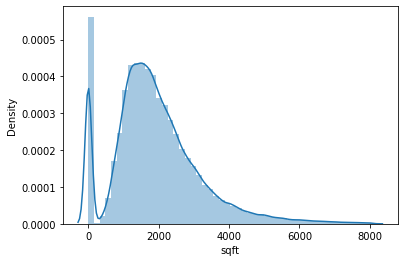

In [41]:
#смотрим: данные также имеют широкий диапазон. Не будем обрезать эти выбросы.
# левая часть графика с низкой площадью относится к типу собственности: land и действительно
# значительно меньше, т.к. там, вероятно просто не указана площадь. С другой стороны 
# варианты с очень большой площадью в небольших количествах также вероятны.
sns.distplot(df['sqft'])

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330299 entries, 0 to 377184
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   propertyType  302797 non-null  object 
 1   street        330297 non-null  object 
 2   baths         330299 non-null  int64  
 3   homeFacts     330299 non-null  object 
 4   fireplace     96842 non-null   object 
 5   city          330282 non-null  object 
 6   schools       330299 non-null  object 
 7   sqft          330299 non-null  float64
 8   zipcode       330299 non-null  object 
 9   beds          263947 non-null  object 
 10  state         330299 non-null  object 
 11  stories       210308 non-null  object 
 12  mls-id        22969 non-null   object 
 13  PrivatePool   37188 non-null   object 
 14  MlsId         270855 non-null  object 
 15  target        330299 non-null  float64
 16  sqft_isNaN    330299 non-null  uint8  
dtypes: float64(2), int64(1), object(13), uint8(1)
me

**zipcode**

In [43]:
df.zipcode.nunique()

4398

In [44]:
#убираем все символы, кроме цифр. Приводим к формату int
regex = re.compile('\D+')
df['zipcode_int'] = df['zipcode'].apply(lambda x: int(regex.sub('', str(x))) if regex.sub('', str(x))!='' else 0)

zipcode - почтовый индекс. Может играть роль территориального признака.

**beds**

In [45]:
print(df.beds.describe())
print("Количество пустых значений: ", df.beds.isna().sum())

count     263947
unique       827
top       3 Beds
freq       49116
Name: beds, dtype: object
Количество пустых значений:  66352


beds - показатель количества спален, он может коррелировать с показателем baths (необходимо обратить на это внимание позжe). Подготовим его данные для перевода в цифровые значения.

In [46]:
# пропуски заполним 0, т.к. это вероятнее всего связано с типом собственности land
df['beds'] = df['beds'].fillna(0)

In [47]:
#преобразуем данные (int, т.к. количество спален должно быть целым)
df['beds'] = df.beds.replace('.0', '', regex=True)
df['beds'] = df.beds.replace('\D', '', regex=True)
df['beds'] = df.beds.replace('', None, regex=True)
df['beds'] = df.beds.replace('\D', '', regex=True).astype(int)

In [48]:
# избавимся от явных выбросов
df.beds = df.beds.apply(lambda x: x if x <= 9 else df.beds.median())

In [49]:
df

,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,sqft_isNaN,zipcode_int
0,Single Family Home,240 Heather Ln,3,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900.0,28387,4.0,NC,NaN,NaN,NaN,611019,418000.0,0,28387
1,single-family home,12911 E Heroy Ave,3,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...",1947.0,99216,3.0,WA,2.0,NaN,NaN,201916904,310000.0,0,99216
2,single-family home,2005 Westridge Rd,2,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...",3000.0,90049,3.0,CA,1.0,NaN,yes,FR19221027,2895000.0,0,90049
3,single-family home,4311 Livingston Ave,8,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...",6457.0,75205,5.0,TX,3.0,NaN,NaN,14191809,2395000.0,0,75205
5,townhouse,1624 S Newkirk St,0,"{'atAGlanceFacts': [{'factValue': '1920', 'fac...",NaN,Philadelphia,"[{'rating': [], 'data': {'Distance': [], 'Grad...",897.0,19145,2.0,PA,2.0,NaN,NaN,PAPH847006,209000.0,0,19145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377179,Condo,2238 11th St NW APT 2,3,"{'atAGlanceFacts': [{'factValue': '2010', 'fac...",NaN,Washington,"[{'rating': ['3/10', '3/10'], 'data': {'Distan...",1417.0,20001,2.0,DC,3.0,NaN,NaN,DCDC444306,799000.0,0,20001
377180,Single Family,20800 NE 23rd Ave,6,"{'atAGlanceFacts': [{'factValue': '1990', 'fac...",NaN,Miami,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...",4017.0,33180,5.0,FL,0.0,NaN,Yes,A10702700,1249000.0,0,33180
377181,condo,3530 N Lake Shore Dr #4B,3,"{'atAGlanceFacts': [{'factValue': '1924', 'fac...",NaN,Chicago,"[{'rating': ['1/10', '5/10', '7/10'], 'data': ...",2000.0,60657,3.0,IL,9.0,NaN,NaN,10374233,674999.0,0,60657
377182,single-family home,15509 Linden Blvd,3,"{'atAGlanceFacts': [{'factValue': '1950', 'fac...",NaN,Jamaica,"[{'rating': ['5/10', '4/10'], 'data': {'Distan...",1152.0,11434,3.0,NY,2,NaN,NaN,NaN,528000.0,0,11434


In [50]:
df.beds.value_counts()

3.0    106140
0.0     71046
4.0     69595
2.0     47487
5.0     21427
1.0      5859
6.0      5789
7.0      1471
8.0      1055
9.0       430
Name: beds, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='beds', ylabel='Density'>

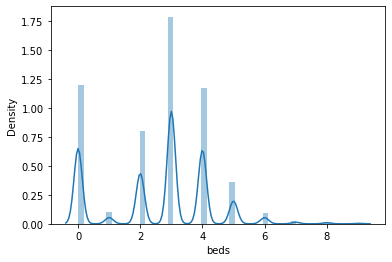

In [51]:
sns.distplot(df['beds'])

**state**

In [52]:
print(df.state.describe())
print("Количество пустых значений: ", df.state.isna().sum())

count     330299
unique        37
top           FL
freq       98262
Name: state, dtype: object
Количество пустых значений:  0


starte - наименование штата. Релевантный признак, который мы сделаем категориальным.

In [53]:
df.sample(2)

,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target,sqft_isNaN,zipcode_int
182619,"Single Detached, Contemporary/Modern",4817 Caxton Ct,0,"{'atAGlanceFacts': [{'factValue': '2018', 'fac...",NaN,Dallas,"[{'rating': ['4', '5', '2', '10'], 'data': {'D...",2346.0,75204,0.0,TX,NaN,NaN,NaN,14219752,650000.0,0,75204
18730,single-family home,8947 S Laflin St,2,"{'atAGlanceFacts': [{'factValue': '1925', 'fac...",NaN,Chicago,"[{'rating': ['1/10', '6/10', '1/10'], 'data': ...",1584.0,60620,4.0,IL,NaN,NaN,NaN,10545919,199000.0,0,60620


**stories**

In [54]:
print(df.stories.describe())
print("Количество пустых значений: ", df.stories.isna().sum())

count     210308
unique       334
top          1.0
freq       62360
Name: stories, dtype: object
Количество пустых значений:  119991


In [55]:
df.stories.value_counts().head(50)

1.0                      62360
2.0                      51502
1                        21507
2                        17107
3.0                      10523
0.0                       6719
One                       5641
0                         4007
3                         3995
9.0                       2837
Two                       2457
2.00                      2325
2 Story                   1961
4.0                       1953
1 Story                   1224
1.00                      1071
3+                         856
4                          813
6.0                        572
Three Or More              534
5.0                        506
3.00                       475
9                          455
1.50                       434
One Story                  383
Townhouse                  325
Ranch/1 Story              289
Multi/Split                267
7.0                        265
Two Story or More          247
8.0                        239
6                          230
2 Storie

In [56]:
# пропуски заполним 0
df['stories'] = df['stories'].fillna(0)

In [57]:
df.stories.isna().sum()

0

In [58]:
df['stories'] = df['stories'].str.lower()
df['stories'] = df.stories.replace('.0+', '', regex=True)
df['stories'] = df.stories.replace('\D', '', regex=True)
df['stories'] = df.stories.replace('', None, regex=True)
df['stories'] = df['stories'].fillna(0)
df['stories'] = df.stories.replace('\D', '', regex=True).astype(int)

In [59]:
# избавимся от явных выбросов
df.stories = df.stories.apply(lambda x: x if x <= 9 else df.stories.mean())

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='stories', ylabel='Density'>

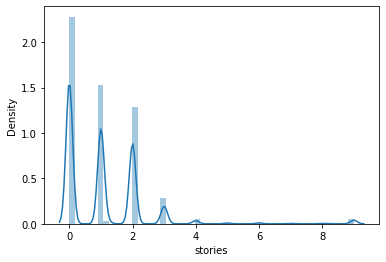

In [60]:
sns.distplot(df['stories'])

stories - этажность дома. Признак с большим количеством пропусков и в целом содеожит достаточно грязные данные, которые могут мешать модели. Возможно, его стоит удалить

**PrivatePool**

In [61]:
df['PrivatePool'] = df['PrivatePool'].fillna('No')
df['PrivatePool'] = df['PrivatePool'].map({'Yes':1, 'No':0, 'yes':1})

PrivatePool - наличие бассейна, сделаем бинарный признак.

**MlsID**

**mls-id**

MlsID -  используется реэлтором как логин в  Multiple Listing System (MLS). Объединим два признака и хешируем данные

In [62]:
#делаем списки идентификаторов и ищем пересечение
s1 = set(df['mls-id'].unique())
s2 = set(df['MlsId'].unique())
s3 = s2.intersection(s1)
print('Пересекаются {0} значений'.format(len(s3)))
print('mls-id = {0} значений, MlsId = {1} значений'.format(len(s1), len(s2)))

Пересекаются 8210 значений
mls-id = 22941 значений, MlsId = 201639 значений


In [63]:
#соединяем идентификаторы в одну колонку, так удобнее с ними работать
df['mls-id'].fillna('', inplace=True)
df['MlsId'].fillna('', inplace=True)
df['new_id']=df['mls-id'].astype(str)+df['MlsId'].astype(str)

#проверяем, может есть строки, в которых идентификатор совсем не проставлен. Эти строки не трогаем, оставляем как есть
print('В {0} строках не проставлен идентификатор'.format(df[df['new_id']=='']['new_id'].count()))

#data=data.drop(['mls-id', 'MlsId'], axis = 'columns')

В 36475 строках не проставлен идентификатор


In [64]:
#остались только обработанные столбцы. Попробуем поискать полные дубликаты
data1 = df.drop_duplicates()
print(len(df), '->', len(data1))

330299 -> 330240


In [65]:
df= data1

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330240 entries, 0 to 377184
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   propertyType  302738 non-null  object 
 1   street        330238 non-null  object 
 2   baths         330240 non-null  int64  
 3   homeFacts     330240 non-null  object 
 4   fireplace     96831 non-null   object 
 5   city          330223 non-null  object 
 6   schools       330240 non-null  object 
 7   sqft          330240 non-null  float64
 8   zipcode       330240 non-null  object 
 9   beds          330240 non-null  float64
 10  state         330240 non-null  object 
 11  stories       330240 non-null  float64
 12  mls-id        330240 non-null  object 
 13  PrivatePool   330240 non-null  int64  
 14  MlsId         330240 non-null  object 
 15  target        330240 non-null  float64
 16  sqft_isNaN    330240 non-null  uint8  
 17  zipcode_int   330240 non-null  int64  
 18  new_

In [67]:
#полные дубликаты удалены. Посчитаем hash для идентификатора. Так как он содержит и буквы тоже
hash_space = 500000
df['new_id'] = df['new_id'].apply(lambda x: hash(''.join(x.lower().split())) % hash_space)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


**school**

In [68]:
print(df.schools.describe())
print("Количество пустых значений: ", df.schools.isna().sum())

count                                                330240
unique                                               259396
top       [{'rating': [], 'data': {'Distance': [], 'Grad...
freq                                                   3210
Name: schools, dtype: object
Количество пустых значений:  0


В данных признака shools - словари, содержащие в себе информацию о близлежащих
к продаваемой собственности школах. Это такие данные как: тип школы, расстояние от дома до школы, рейтинг школы и название школы. В далнейшем, если будет достаточно времени, можно создать дополнительные признаки по ряду вышеперечисленных параметров. Сам признак удалим.

In [69]:
#функция для количества школ
def school_count(value):
    try:
        x = len(pd.DataFrame(dict(le(value)[0])['data']))
        return int(x)
    except:
        return 0

In [70]:
#замерим скорость каждой операции и определим порядок парсинга(т.к. в процессе данные будем убирать,
# чем ускорим обработку низкоскоростных операций):
%timeit school_count(df['schools'][17])

369 µs ± 3.57 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [71]:
#убедимся, что в оставшемся датасете нет пропусков в школах
df['schools'].isnull().value_counts()

False    330240
Name: schools, dtype: int64

In [72]:
df['school_count'] = df['schools'].progress_apply(school_count)

100%|██████████| 330240/330240 [02:06<00:00, 2606.70it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [73]:
df.school_count.value_counts()

3     186757
2      31944
8      30912
5      26645
4      20535
6       8684
0       8268
1       6760
7       4278
24      1800
10       595
11       586
22       399
65       344
9        304
63       292
13       249
12       219
14       154
49       149
61       111
16       106
21        76
15        63
26         6
17         4
Name: school_count, dtype: int64

**city**

In [74]:
CRIMESE  = '../input/crimese/'

In [75]:
print(df.city.describe())
print("Количество пустых значений: ", df.city.isna().sum())

count      330223
unique       1906
top       Houston
freq        22357
Name: city, dtype: object
Количество пустых значений:  17


In [76]:
df['city'].duplicated().sum()

328333

По данному показателю стоит поработать со сторонними данными, такими как количество населения, сам показатель затем категоризировать

In [77]:
!pip install openpyxl

     |████████████████████████████████| 242 kB 5.1 MB/s            


In [78]:
city = pd.read_excel(CRIMESE+'city_crime.xlsx')

In [79]:
#с kaggle взят dataset c количеством преступлений по городам за 2018 и 2019 года.
#преобразуем данные для нашего dataset
#city = pd.read_excel('city_crime.xlsx')
city = city.dropna()
city['City'] = city['City'].str.lower()
del city['State']
city['crimes_pop'] = 0
for i in city.columns[3:]:
    city['crimes_pop'] += city[i]
    del city[i]
    if i == 'Arson':
        city['crimes_pop'] = city['crimes_pop'] / city['Population']
        break
del city['Year']
city['City'] = city['City'].str.lower()
city_crime = city.groupby(['City']).mean()

In [80]:
#мы получили метрики: средний за два года уровень преступности по городам, популяция 
city_crime.head(3)

,Population,crimes_pop
City,,
abilene,122480.0,0.032173
akron,197690.0,0.040652
albuquerque,560235.0,0.072329


In [81]:
city_crime.info()

<class 'pandas.core.frame.DataFrame'>
Index: 255 entries, abilene to yonkers
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Population  255 non-null    float64
 1   crimes_pop  255 non-null    float64
dtypes: float64(2)
memory usage: 6.0+ KB


In [82]:
df['city'] = df['city'].str.lower()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [83]:
df_new = pd.merge(df, city_crime, how='left', left_on='city', right_on='City')

In [84]:
df = df_new

In [85]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330240 entries, 0 to 330239
Data columns (total 22 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   propertyType  302738 non-null  object 
 1   street        330238 non-null  object 
 2   baths         330240 non-null  int64  
 3   homeFacts     330240 non-null  object 
 4   fireplace     96831 non-null   object 
 5   city          330223 non-null  object 
 6   schools       330240 non-null  object 
 7   sqft          330240 non-null  float64
 8   zipcode       330240 non-null  object 
 9   beds          330240 non-null  float64
 10  state         330240 non-null  object 
 11  stories       330240 non-null  float64
 12  mls-id        330240 non-null  object 
 13  PrivatePool   330240 non-null  int64  
 14  MlsId         330240 non-null  object 
 15  target        330240 non-null  float64
 16  sqft_isNaN    330240 non-null  uint8  
 17  zipcode_int   330240 non-null  int64  
 18  new_

In [86]:
df['crimes_pop'] = df['crimes_pop'].fillna(df.crimes_pop.mean())

In [87]:
df['Population'] = df['Population'].fillna(df.Population.mean())

В итоге получено два признака: Population - количество населения и crimes_pop - средняя плотность преступлений в этих городах.

In [88]:
df['city'] = df['city'].fillna('other')
top_city = df['city'].value_counts()[:200].index
df['city'] = df['city'].apply(lambda r: r if r in top_city else 'other')

In [89]:
# преобразуем данные признака education в числовые категории
mapped = pd.Series(label_encoder.fit_transform(df['city']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'albany', 1: 'amarillo', 2: 'anaheim', 3: 'antioch', 4: 'arlington', 5: 'asheville', 6: 'atlanta', 7: 'aurora', 8: 'austin', 9: 'aventura', 10: 'bainbridge island', 11: 'bal harbour', 12: 'bay harbor islands', 13: 'beaumont', 14: 'bellevue', 15: 'bellingham', 16: 'bonita springs', 17: 'boston', 18: 'brandon', 19: 'bronx', 20: 'brooklyn', 21: 'brownsville', 22: 'bryan', 23: 'buffalo', 24: 'cape coral', 25: 'cary', 26: 'charlotte', 27: 'chattanooga', 28: 'chicago', 29: 'cincinnati', 30: 'clarksville', 31: 'clearwater', 32: 'cleveland', 33: 'cleveland heights', 34: 'college station', 35: 'columbus', 36: 'concord', 37: 'conroe', 38: 'coral gables', 39: 'coral springs', 40: 'crystal lake', 41: 'cutler bay', 42: 'dallas', 43: 'davie', 44: 'deltona', 45: 'denton', 46: 'denver', 47: 'detroit', 48: 'doral', 49: 'durham', 50: 'el paso', 51: 'englewood', 52: 'everett', 53: 'fairfield', 54: 'fayetteville', 55: 'flushing', 56: 'fort lauderdale', 57: 'fort worth', 58: 'fremont', 59: 'fresno', 60

In [90]:
df['city'] = label_encoder.fit_transform(df['city'])
df.sample(3)

,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,...,mls-id,PrivatePool,MlsId,target,sqft_isNaN,zipcode_int,new_id,school_count,Population,crimes_pop
91673,Single Family,3195 N Dahlia Ln,2,"{'atAGlanceFacts': [{'factValue': '2016', 'fac...",NaN,129,"[{'rating': ['7/10', '8/10', '8/10'], 'data': ...",1874.0,47404,3.0,...,201951182,0,,294000.0,0,47404,191698,3,803096.915018,0.039052
215548,single-family home,612 E Powell Ave,2,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,57,"[{'rating': ['4/10', '4/10', '6/10'], 'data': ...",1360.0,76104,3.0,...,,0,14229552,185000.0,0,76104,99531,3,803096.915018,0.039052
277110,coop,6930 Kissena Blvd #2,0,"{'atAGlanceFacts': [{'factValue': '1945', 'fac...",NaN,55,"[{'rating': ['8/10', '4/10'], 'data': {'Distan...",720.0,11367,0.0,...,,0,3133349,228000.0,0,11367,126093,2,803096.915018,0.039052


**fireplace**

In [91]:
print(df.fireplace.describe())
print("Количество пустых значений: ", df.fireplace.isna().sum())

count     96831
unique     1586
top         yes
freq      46619
Name: fireplace, dtype: object
Количество пустых значений:  233409


Признак fireplace - камин, указывает на количество каминов в доме. Стоит поработать с этим признаком.

In [92]:
def make_fireplace(x):
    if x == 0: return x
    x = x.lower()
    x = re.sub('yes', '1', x)
    x = re.sub('no', '0', x)
    if 'fireplace' in x: 
        x = '1'
    try:
        x = int(x)
    except:
        x = 0
    return x

In [93]:
df['fireplace'] = df['fireplace'].fillna(0)
df['fireplace'] = df['fireplace'].apply(make_fireplace)

In [94]:
df['fireplace'] = df['fireplace'].apply(lambda x: 5 if x >= 5 else x)

In [95]:
df.fireplace.value_counts()

0    244083
1     83119
2      2338
3       506
4       128
5        66
Name: fireplace, dtype: int64

**homeFacts**

In [96]:
df['homeFacts'][0]

"{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}"

In [97]:
#смотрим, какие списки внутри. 
for i in df['homeFacts']:
    fact_list = []
    hf = eval(i)['atAGlanceFacts']
    for k in hf:
        fact_list.append(k['factLabel'])
set(fact_list)

{'Cooling',
 'Heating',
 'Parking',
 'Price/sqft',
 'Remodeled year',
 'Year built',
 'lotsize'}

In [98]:
def make_facts(row, columns):
    fact_dict = {}
    for i in columns:
        fact_dict[i]=float('nan')
    row = eval(row)['atAGlanceFacts']
    for i in row:
        fact_dict[i['factLabel']]=i['factValue']
    return pd.Series(fact_dict)

In [99]:
fact_columns = ['Cooling',  'Heating', 'Parking', 'Price/sqft', 'Remodeled year', 'Year built', 'lotsize']
df[fact_columns]=df['homeFacts'].apply(lambda x: make_facts(x,fact_columns))

In [100]:
df[fact_columns]

,Cooling,Heating,Parking,Price/sqft,Remodeled year,Year built,lotsize
0,,"Central A/C, Heat Pump",,$144,,2019,None
1,,,,$159/sqft,,2019,5828 sqft
2,Central,Forced Air,Attached Garage,$965/sqft,1967,1961,"8,626 sqft"
3,Central,Forced Air,Detached Garage,$371/sqft,2006,2006,"8,220 sqft"
4,Central,Forced Air,,$233/sqft,,1920,680 sqft
...,...,...,...,...,...,...,...
330235,Central,Forced air,1 space,$564,None,2010,None
330236,Central,Other,2 spaces,$311,1990,1990,"8,500 sqft"
330237,,Radiant,None,$337/sqft,,1924,
330238,,Other,2,$458/sqft,1950,1950,"1,600 sqft"


homeFacts - признак, который содержит в себе данные по дате строительства дома. Стоит поработать над ним.

In [101]:
#Cooling, Heating, Parking меняем на 1 (есть), 0(нет)
for i in ['Cooling', 'Heating', 'Parking']:
    df[i].fillna(0, inplace = True)
    df[i] = df[i].apply(lambda x: 0 if x == np.nan or x in ['', 'No','None', 'no', 0, 'No Data'] else 1)

In [102]:
#преобразуем год в число
for i in ['Remodeled year', 'Year built']:
    df[i.split()[0]] = df[i].apply(lambda x: int(x) if str(x) not in ['', 'None','No Data'] else 0)

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330240 entries, 0 to 330239
Data columns (total 31 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   propertyType    302738 non-null  object 
 1   street          330238 non-null  object 
 2   baths           330240 non-null  int64  
 3   homeFacts       330240 non-null  object 
 4   fireplace       330240 non-null  int64  
 5   city            330240 non-null  int64  
 6   schools         330240 non-null  object 
 7   sqft            330240 non-null  float64
 8   zipcode         330240 non-null  object 
 9   beds            330240 non-null  float64
 10  state           330240 non-null  object 
 11  stories         330240 non-null  float64
 12  mls-id          330240 non-null  object 
 13  PrivatePool     330240 non-null  int64  
 14  MlsId           330240 non-null  object 
 15  target          330240 non-null  float64
 16  sqft_isNaN      330240 non-null  uint8  
 17  zipcode_in

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330240 entries, 0 to 330239
Data columns (total 31 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   propertyType    302738 non-null  object 
 1   street          330238 non-null  object 
 2   baths           330240 non-null  int64  
 3   homeFacts       330240 non-null  object 
 4   fireplace       330240 non-null  int64  
 5   city            330240 non-null  int64  
 6   schools         330240 non-null  object 
 7   sqft            330240 non-null  float64
 8   zipcode         330240 non-null  object 
 9   beds            330240 non-null  float64
 10  state           330240 non-null  object 
 11  stories         330240 non-null  float64
 12  mls-id          330240 non-null  object 
 13  PrivatePool     330240 non-null  int64  
 14  MlsId           330240 non-null  object 
 15  target          330240 non-null  float64
 16  sqft_isNaN      330240 non-null  uint8  
 17  zipcode_in

In [105]:
df['Year'] = df['Year'].fillna(df['Year'].median())

In [106]:
#посмотрим на 'края' и уберём их
x = df['Year'].quantile(0.13)
y = df['Year'].quantile(.99)
print(x)
print(y)
df['Year'] = df['Year'].where(df['Year'] >= x)
df['Year'] = df['Year'].where(df['Year'] <= y)
#df = df.dropna(subset=['year_built'])

1890.0
2019.0


In [107]:
#df['year_built'] = df.year_built.apply (lambda x: df.year_built.mean() if x == -1 else x)

In [108]:
#удаляем обработанные столбцы
df = df.drop(['lotsize', 'Remodeled year', 'Year built', 'Price/sqft'], axis = 'columns')

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Year', ylabel='Density'>

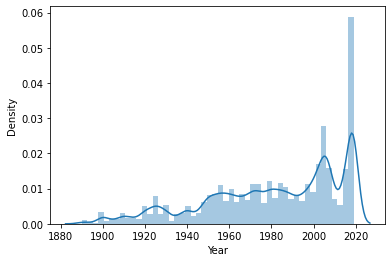

In [109]:
sns.distplot(df['Year'])

In [110]:
df['Year'] = df['Year'].fillna(df['Year'].median())

In [111]:
df.sample(5)

,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,...,zipcode_int,new_id,school_count,Population,crimes_pop,Cooling,Heating,Parking,Remodeled,Year
315782,Single Family,6318 Oak Chase Ct,3,"{'atAGlanceFacts': [{'factValue': '2011', 'fac...",0,128,"[{'rating': ['6/10'], 'data': {'Distance': ['1...",2529.0,32819,4.0,...,32819,0,1,286679.000000,0.052845,1,1,1,2011,2011.0
137355,single-family home,2975 E Stauning Cv,6,"{'atAGlanceFacts': [{'factValue': '2002', 'fac...",0,164,"[{'rating': ['7/10', '6/10', '8/10'], 'data': ...",5118.0,84121,6.0,...,84121,407772,3,202633.000000,0.063010,0,0,0,0,2002.0
209961,single-family home,Winston European Plan in Heather Glen,2,"{'atAGlanceFacts': [{'factValue': '2017', 'fac...",0,154,"[{'rating': ['3/10', '4/10'], 'data': {'Distan...",2225.0,27603,4.0,...,27603,0,2,803096.915018,0.039052,0,0,0,0,2017.0
79658,Single Family,7417 Germanshire Ln,2,"{'atAGlanceFacts': [{'factValue': '1987', 'fac...",1,106,"[{'rating': ['4/10', '3/10'], 'data': {'Distan...",1808.0,38125,4.0,...,38125,0,2,652226.000000,0.079290,1,1,1,0,1987.0
18606,Traditional,6807 Red Maple Dr,1,"{'atAGlanceFacts': [{'factValue': '1996', 'fac...",0,26,"[{'rating': ['6', '9', '7'], 'data': {'Distanc...",2243.0,28277,0.0,...,28277,11766,3,803096.915018,0.039052,1,0,0,0,1996.0


In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330240 entries, 0 to 330239
Data columns (total 27 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   propertyType  302738 non-null  object 
 1   street        330238 non-null  object 
 2   baths         330240 non-null  int64  
 3   homeFacts     330240 non-null  object 
 4   fireplace     330240 non-null  int64  
 5   city          330240 non-null  int64  
 6   schools       330240 non-null  object 
 7   sqft          330240 non-null  float64
 8   zipcode       330240 non-null  object 
 9   beds          330240 non-null  float64
 10  state         330240 non-null  object 
 11  stories       330240 non-null  float64
 12  mls-id        330240 non-null  object 
 13  PrivatePool   330240 non-null  int64  
 14  MlsId         330240 non-null  object 
 15  target        330240 non-null  float64
 16  sqft_isNaN    330240 non-null  uint8  
 17  zipcode_int   330240 non-null  int64  
 18  new_

**propertyType**

In [113]:
print(df.propertyType.describe())
print(df.propertyType.value_counts().head(30))

count                 302738
unique                  1236
top       single-family home
freq                   84874
Name: propertyType, dtype: object
single-family home               84874
Single Family                    58625
Single Family Home               30105
condo                            24666
Condo                            15619
townhouse                        10850
lot/land                         10350
Condo/Townhome/Row Home/Co-Op     7454
multi-family                      6872
Townhouse                         6648
Traditional                       5735
Land                              4067
Multi Family                      2440
coop                              2250
High Rise                         1775
Ranch                             1693
Detached, One Story               1603
Single Detached, Traditional      1565
Contemporary                      1536
1 Story                           1190
Multi-Family Home                 1178
Colonial                       

In [114]:
df['propertyType'] = df.propertyType.apply(lambda x: 'single' if x == 'single-family home' or x == 
                                            'Single Family' or x == 'Single Family Home' else 'condo' 
                                            if x == 'condo' or x == 'Condo' or x == 
                                            'Condo/Townhome/Row Home/Co-Op' else 'land' if x == 'lot/land' 
                                            or x == 'Land' else 'townhouse' if x == 'townhouse' or x == 'Townhouse' 
                                            else 'other')

In [115]:
df.propertyType.unique()

array(['single', 'townhouse', 'other', 'condo', 'land'], dtype=object)

<bound method Axes.barh of <AxesSubplot:>>

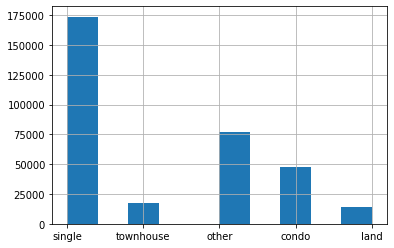

In [116]:
df.propertyType.hist().barh

In [117]:
df.propertyType.value_counts()

single       173604
other         76982
condo         47739
townhouse     17498
land          14417
Name: propertyType, dtype: int64

Признак propertyType - тип собственности. Признак имеет 1280 уникальных значений, что крайне много. При этом видно, что основное количество данных сосредоточено по нескольким значениям single house, condo, land, tawnhouse. Стоит очистить этот признак, остальным уникальным значениям присвоить статус others, чтобы затем было легче перевести данный признак в категориальный.

In [118]:
mapped = pd.Series(label_encoder.fit_transform(df['propertyType']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'condo', 1: 'land', 2: 'other', 3: 'single', 4: 'townhouse'}


In [119]:
df['propertyType1'] = label_encoder.fit_transform(df['propertyType'])
df.sample(3)

,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,...,new_id,school_count,Population,crimes_pop,Cooling,Heating,Parking,Remodeled,Year,propertyType1
294737,other,2000 SW 33rd Ave,1,"{'atAGlanceFacts': [{'factValue': '1958', 'fac...",0,56,"[{'rating': ['3', '4', '3'], 'data': {'Distanc...",1611.0,33312,4.0,...,22229,3,182150.000000,0.054623,1,1,0,1958,1958.0,2
39378,other,7892 Mountain Ash Ln,0,"{'atAGlanceFacts': [{'factValue': '2004', 'fac...",1,129,"[{'rating': ['NR', '6', '7', '7'], 'data': {'D...",1850.0,43110,0.0,...,353252,4,803096.915018,0.039052,1,1,0,0,2004.0,2
36233,single,7271 Waterwheel St SW #159,3,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",0,36,"[{'rating': ['4/10', '8/10', '4/10'], 'data': ...",3015.0,28025,5.0,...,471364,3,130855.000000,0.037450,1,1,1,0,2019.0,3


In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330240 entries, 0 to 330239
Data columns (total 28 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   propertyType   330240 non-null  object 
 1   street         330238 non-null  object 
 2   baths          330240 non-null  int64  
 3   homeFacts      330240 non-null  object 
 4   fireplace      330240 non-null  int64  
 5   city           330240 non-null  int64  
 6   schools        330240 non-null  object 
 7   sqft           330240 non-null  float64
 8   zipcode        330240 non-null  object 
 9   beds           330240 non-null  float64
 10  state          330240 non-null  object 
 11  stories        330240 non-null  float64
 12  mls-id         330240 non-null  object 
 13  PrivatePool    330240 non-null  int64  
 14  MlsId          330240 non-null  object 
 15  target         330240 non-null  float64
 16  sqft_isNaN     330240 non-null  uint8  
 17  zipcode_int    330240 non-nul

In [121]:
df.sample(2)

,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,...,new_id,school_count,Population,crimes_pop,Cooling,Heating,Parking,Remodeled,Year,propertyType1
98119,single,16038 Miami Way,3,"{'atAGlanceFacts': [{'factValue': '1947', 'fac...",1,129,"[{'rating': ['8/10', '8/10', '8/10'], 'data': ...",2228.0,90272,4.0,...,80348,3,803096.915018,0.039052,0,1,1,1970,1947.0,3
249775,single,71 Purple Jasmine,4,"{'atAGlanceFacts': [{'factValue': '2013', 'fac...",0,75,"[{'rating': ['9/10', '10/10', '9/10'], 'data':...",2889.0,92620,4.0,...,352970,3,288052.000000,0.013005,1,1,1,0,2013.0,3


In [122]:
df.fireplace.value_counts()

0    244083
1     83119
2      2338
3       506
4       128
5        66
Name: fireplace, dtype: int64

# Визуализация и анализ взаимного влияния данных

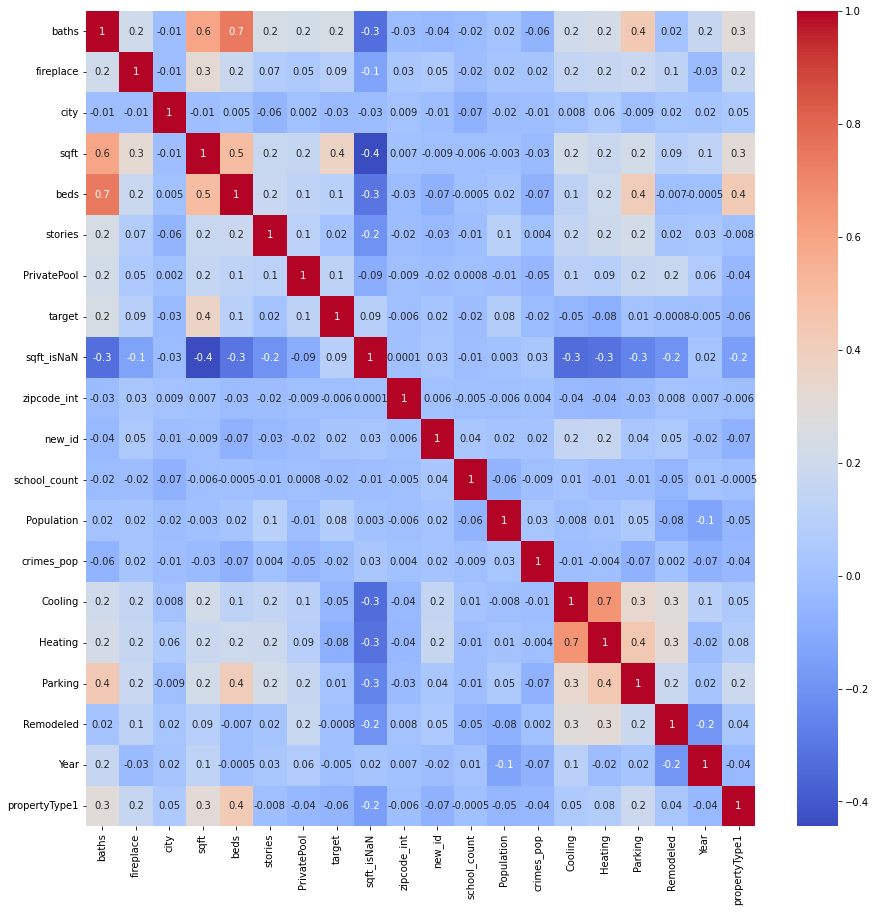

In [123]:
# корреляция

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax = sns.heatmap(df.corr(),fmt='.1g',
                 annot=True, cmap='coolwarm')

На тепловом графике видно, что на цену оказывают наибольшее влияние показатели площади и количества ванных комнат. Заметно влияние кол-ва населения на преступность, что выглядит логично.

In [124]:
cat_cols = ['baths', 'stories', 'beds', 'PrivatePool', 'Year', 'propertyType1', 'school_count', 'Remodeled', 'city']

In [125]:
num_cols = ['sqft', 'Population', 'crimes_pop', 'zipcode_int', 'new_id']

In [126]:
bin_cols = ['fireplace', 'Cooling', 'Heating', 'Parking', 'sqft_isNaN']

Проверим влияние разных типов данных на целевую переменную

In [127]:
from pandas import Series
from sklearn.feature_selection import f_classif, mutual_info_classif

<AxesSubplot:>

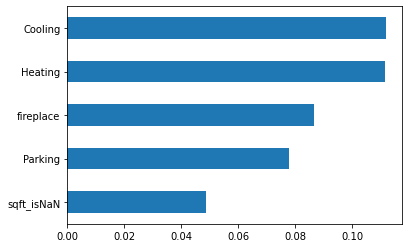

In [128]:
imp_cat = Series(mutual_info_classif(df[bin_cols], df['target'],
                                     discrete_features=True), index=bin_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

<AxesSubplot:>

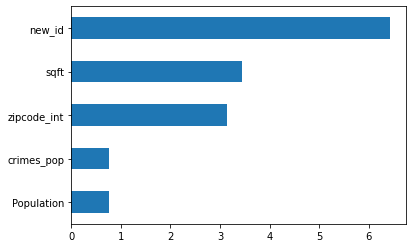

In [129]:
imp_cat = Series(mutual_info_classif(df[num_cols], df['target'],
                                     discrete_features=True), index=num_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

<AxesSubplot:>

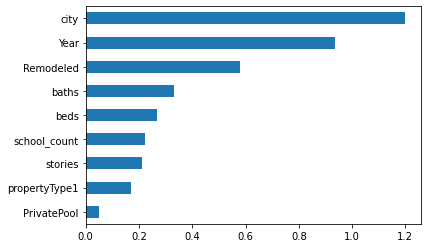

In [130]:
imp_cat = Series(mutual_info_classif(df[cat_cols], df['target'],
                                     discrete_features=True), index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

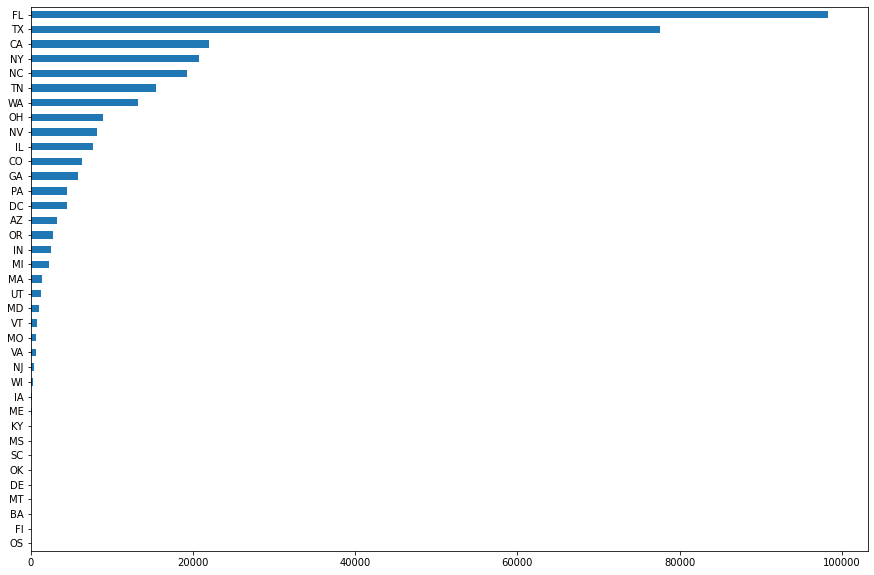

In [131]:
plt.figure(figsize=(15,10))
df['state'].value_counts(ascending=True).plot(kind='barh')
plt.show()

Наибольшее количество предложений о продаже в штате Флорида, затем в Техасе, на тертьем месте Калифорния. Это может как отражать особенность состояния рынка недвижимости в стране, так и просто быть особенностью конкретной базы данных.

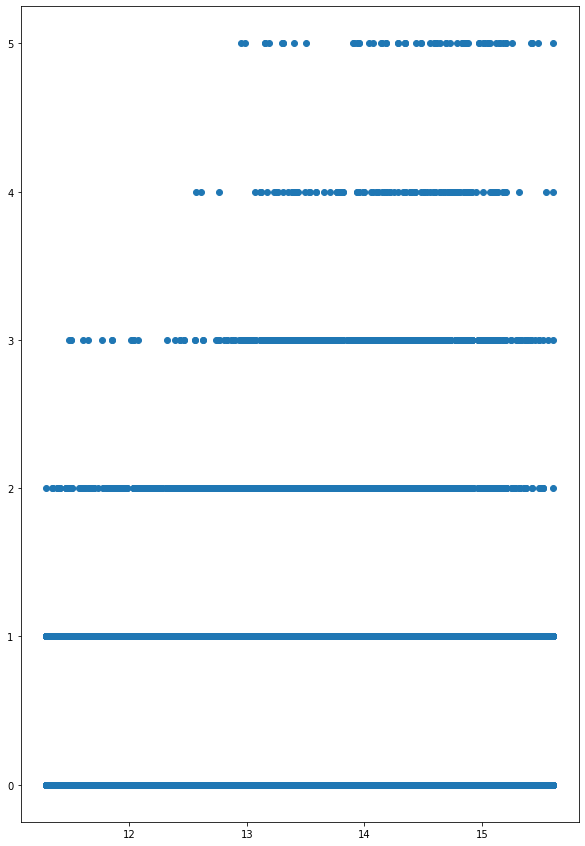

In [132]:
plt.figure(figsize=(10, 15))
plt.scatter(np.log(df.target), df.fireplace)

В качестве разнообразия можно посмотреть распределение зависимости тех или иных признаков от цены. Зависимость признака количества каминов выглядит логично.

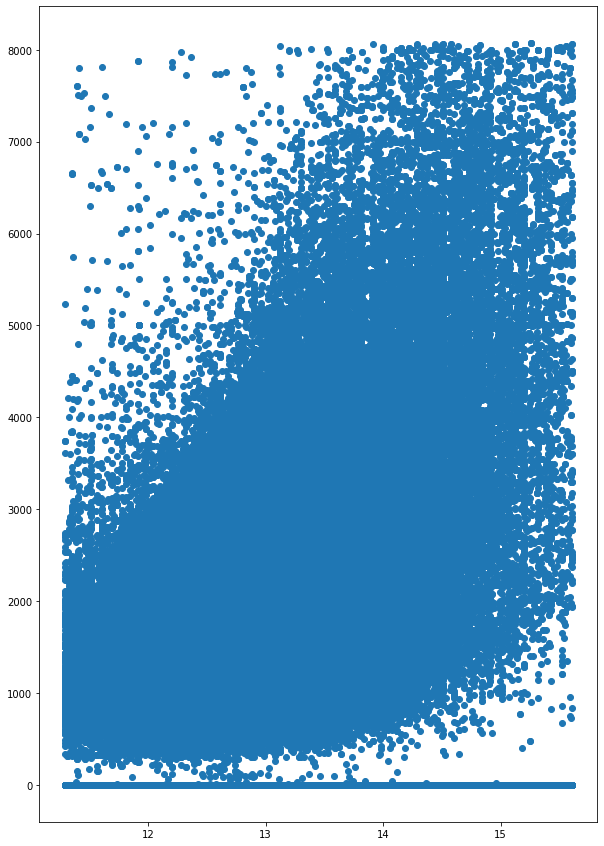

In [133]:
# зависимость цены от площади
plt.figure(figsize=(10, 15))
plt.scatter(np.log(df.target), df.sqft)

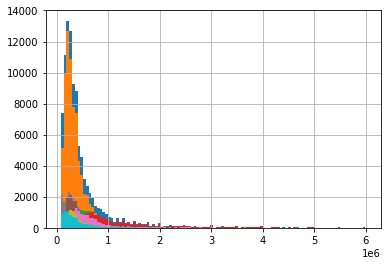

In [134]:
# посмотрим на топ 10 штатов
for x in (df['state'].value_counts())[0:10].index:
    df['target'][df['state'] == x].hist(bins=110)
plt.show()

Распределение объектов по штатам выглядит нормальным.

In [135]:
from sklearn.preprocessing import PolynomialFeatures

In [136]:
# добавим новые полиномиальные признаки, 
# которые являются мат. комбинациями числовых признаков
pf = PolynomialFeatures(2, include_bias=False)
poly_data = pf.fit_transform(df[num_cols])[:, len(num_cols):]
poly_cols = pf.get_feature_names()[len(num_cols):]
poly_df = pd.DataFrame(poly_data, columns=poly_cols)
df = df.join(poly_df,  how='left')

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330240 entries, 0 to 330239
Data columns (total 43 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   propertyType   330240 non-null  object 
 1   street         330238 non-null  object 
 2   baths          330240 non-null  int64  
 3   homeFacts      330240 non-null  object 
 4   fireplace      330240 non-null  int64  
 5   city           330240 non-null  int64  
 6   schools        330240 non-null  object 
 7   sqft           330240 non-null  float64
 8   zipcode        330240 non-null  object 
 9   beds           330240 non-null  float64
 10  state          330240 non-null  object 
 11  stories        330240 non-null  float64
 12  mls-id         330240 non-null  object 
 13  PrivatePool    330240 non-null  int64  
 14  MlsId          330240 non-null  object 
 15  target         330240 non-null  float64
 16  sqft_isNaN     330240 non-null  uint8  
 17  zipcode_int    330240 non-nul

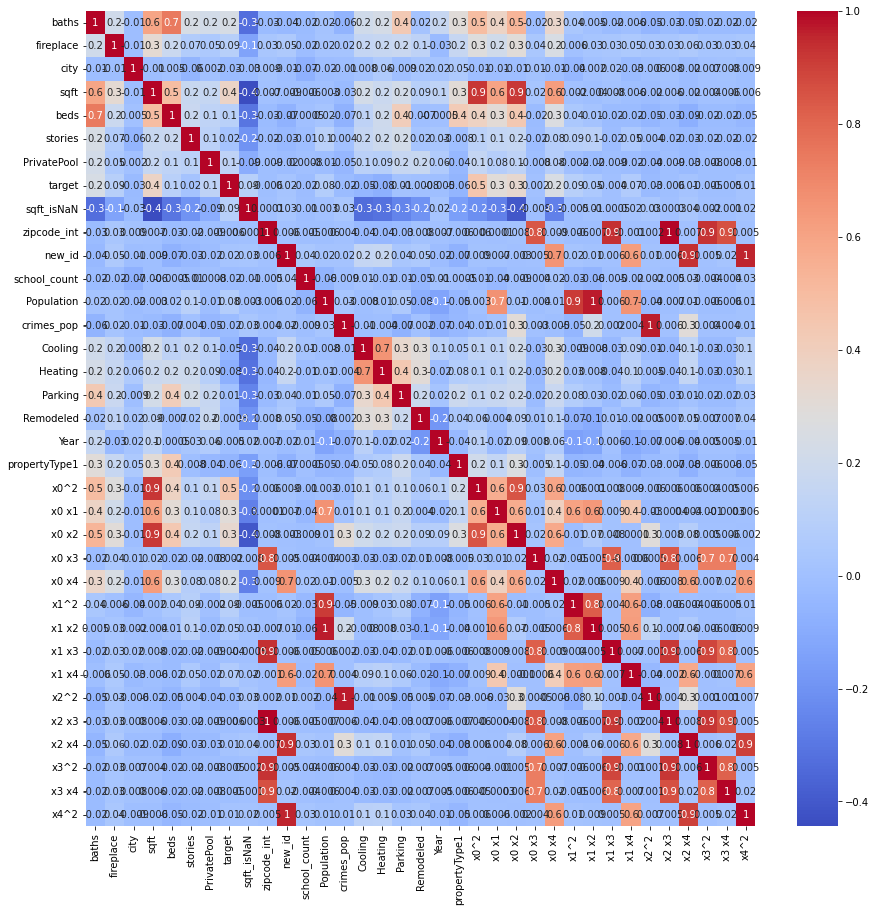

In [138]:
# корреляция

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax = sns.heatmap(df.corr(),fmt='.1g',
                 annot=True, cmap='coolwarm')

In [139]:
# график корреляции показал, что ряд полиномиальных признаков лучше удалить
df = df.drop(columns = ['x0^2', 'x0 x2', 'x1^2', 'x1 x2', 'x1 x3', 'x2^2', 'x2 x3', 'x2 x4', 'x3^2', 'x3 x4', 'x4^2'])

In [140]:
df = pd.concat([df, pd.get_dummies(df['state'])], axis=1)

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330240 entries, 0 to 330239
Data columns (total 69 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   propertyType   330240 non-null  object 
 1   street         330238 non-null  object 
 2   baths          330240 non-null  int64  
 3   homeFacts      330240 non-null  object 
 4   fireplace      330240 non-null  int64  
 5   city           330240 non-null  int64  
 6   schools        330240 non-null  object 
 7   sqft           330240 non-null  float64
 8   zipcode        330240 non-null  object 
 9   beds           330240 non-null  float64
 10  state          330240 non-null  object 
 11  stories        330240 non-null  float64
 12  mls-id         330240 non-null  object 
 13  PrivatePool    330240 non-null  int64  
 14  MlsId          330240 non-null  object 
 15  target         330240 non-null  float64
 16  sqft_isNaN     330240 non-null  uint8  
 17  zipcode_int    330240 non-nul

In [142]:
# удалим ненужные признаки
df = df.drop(columns = ['propertyType','street','homeFacts','schools','zipcode','state', 'mls-id', 'MlsId'], axis=1)

In [143]:
#сохраняем обработанный датасет
df.to_csv('data_diplom.csv', encoding='utf-8', index=False)

Дальнейший анализ признаков, использование некоторых методов feature_selection на моделях показал, что сохраненный выше датасет имеет наилучшее соотношение признаков и дальнейшие манипуляции с ними не имеют положительных результатов.

# Анализ признаков обработанного датасета

In [144]:
# функция для отбора К лучших признаков по их статистической близости к целевой переменной
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression # числовые признаки и числовой выходной признак
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier

In [145]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html
from sklearn.linear_model import LinearRegression, BayesianRidge
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html?highlight=sgdregressor
from sklearn.linear_model import SGDRegressor
# https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
from sklearn.tree import DecisionTreeRegressor
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html?highlight=kneighborsregressor
from sklearn.neighbors import KNeighborsRegressor
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html?highlight=svr#sklearn.svm.SVR
from sklearn.svm import SVR
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html?highlight=randomforestregressor#sklearn.ensemble.RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html?highlight=randomforestregressor
from sklearn.ensemble import ExtraTreesRegressor
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor
from sklearn.ensemble import AdaBoostRegressor
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html?highlight=randomforestregressor
from sklearn.ensemble import GradientBoostingRegressor
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html#sklearn.ensemble.StackingRegressor
from sklearn.ensemble import StackingRegressor
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html#sklearn.ensemble.VotingRegressor
from sklearn.ensemble import VotingRegressor
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html#sklearn.ensemble.BaggingRegressor
from sklearn.ensemble import BaggingRegressor
import sklearn.metrics as metrics

In [146]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.2, random_state=RANDOM_SEED)

In [147]:
# обучаем функцию выбора на основе критерия кси-квадрат и извлекаем лучшие 50 признаков'''
bestfeatures = SelectKBest(score_func=f_regression, k=50)
fit = bestfeatures.fit(x_train,y_train)
# создаем набор данных признаков с их весом и выбираем 50 лучших'''
featureScores =  pd.DataFrame({'Features':x_train.columns, 'Score': fit.scores_})
print(featureScores.nlargest(50,'Score'))

         Features         Score
3            sqft  41886.709912
19          x0 x1  26419.577047
21          x0 x4  17727.846322
0           baths  16868.179547
46             NY  16532.318888
25             CA   8062.003436
6     PrivatePool   4152.033802
54             TX   2702.054908
4            beds   2658.238645
1       fireplace   2367.890145
7      sqft_isNaN   2176.835750
14        Heating   1758.932913
11     Population   1480.502766
22          x1 x4   1238.520500
47             OH   1221.376225
18  propertyType1    892.112078
43             NC    699.611491
13        Cooling    664.242709
27             DC    589.111324
29             FL    511.535975
36             MA    487.066265
53             TN    448.640357
58             WA    375.336852
39             MI    364.383118
23             AZ    317.896288
2            city    281.934601
34             IN    244.445823
51             PA    186.728845
12     crimes_pop    134.183344
9          new_id    124.990485
45      

In [148]:
# тут стоит поиграть с количеством признаков и пронаблюдать результаты
x_train_1 = x_train[featureScores.nlargest(45,'Score').Features.values]
x_test_1 = x_test[featureScores.nlargest(45,'Score').Features.values]
my_lr_1 = LinearRegression()
my_lr1 = my_lr_1.fit(x_train_1, np.log(y_train+1))

In [149]:
predict_test1 = np.exp(my_lr1.predict(x_test_1))

In [150]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [151]:
print(mape(y_test, predict_test1))

0.45327504252774925


In [152]:
def SMAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(2*np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

In [153]:
print(SMAPE(y_test, predict_test1))

0.3896202673869702


Результаты метрик на модели линейной регрессии не дали лучших результатов

In [154]:
#data_source = pd.read_csv(DATA+'data.csv')

In [155]:
#columns = list(set(df.columns) - set(['target']))
#X = df[columns]
#y = df['target']

#columns_source = list(set(data_source.columns) - set(['target']))
#X_source = data_source[columns_source]
#y_source = data_source['target']'''

In [156]:
# Признаки - в train, метки - в train_labels
#fs = FeatureSelector(data = X, labels = y)
#fs_source = FeatureSelector(data = X_source, labels = y_source)

In [157]:
#print('Обработанный датасет')
#print('Исходный датасет')
#fs_source.identify_missing(missing_threshold = 0.6)

In [158]:
#Посмотрим на то, какие же признаки в обработанном датасете слишком взаимосвязаны
#fs.plot_collinear()

In [159]:
#fs.identify_zero_importance(task = 'regression', 
#                            eval_metric = 'l2', 
#                            n_iterations = 10, 
#                            early_stopping = False)

#zero_importance_features = fs.ops['zero_importance']

In [160]:
#fs.identify_low_importance(cumulative_importance = 0.99)

In [161]:
#эти признаки предлагается удалить (10 штук)
#fs.feature_importances.tail(10)

# Обучение

In [162]:
# проведем классическое разделение датасета
x_train, x_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.2, random_state=RANDOM_SEED)

In [163]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((264192, 60), (264192,), (66048, 60), (66048,))

In [164]:
# начнем с линейной регрессии
from sklearn.linear_model import LinearRegression
linear_regr = LinearRegression().fit(x_train, np.log(y_train+1))

In [165]:
predict_test = np.exp(linear_regr.predict(x_test))

In [166]:
def SMAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(2*np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

In [167]:
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [168]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [169]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 45.22%


In [170]:
print(f"Точность модели по метрике SMAPE: {(SMAPE(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике SMAPE: 38.95%


Наиболее часто используемая в бизнесе и легко интерпритируемая метрика - MAPE. Вместе с тем, особенности нашего датасета могут негативно влиять на эту метрику. Для устранения некоторых искажений (н-р 0 в знаменателе) будем использовать метрику SMAPE.
SMAPE - Symmetric MAPE.
При этом в следующих моделях постараемся рассмотреть весь ансамбль метрик для объективного анализа

In [171]:
# xgboost

x_train, x_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.2, random_state=RANDOM_SEED)
import xgboost as xgb
xb = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.03, \
                      max_depth=12, alpha=1, n_jobs=-1, n_estimators=1000)
xb.fit(x_train, np.log(y_train+1))
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(xb.predict(x_test))))*100:0.2f}%")
print(f"Точность модели по метрике SMAPE: {(SMAPE(y_test, np.exp(xb.predict(x_test))))*100:0.2f}%")


Точность модели по метрике MAPE: 22.34%
Точность модели по метрике SMAPE: 20.84%


In [172]:
from catboost import CatBoostRegressor

In [173]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(x_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(x_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

In [174]:
predict = model.predict(x_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 36.95%


import pandas as pd
import numpy as np
import pickle                                                        #для сохранения модели
from sklearn.model_selection import train_test_split                 #для разбиения данных на выборки
from sklearn import metrics                                          #метрики
from sklearn.linear_model import LinearRegression                    #линейная регрессия
from sklearn.ensemble import RandomForestRegressor                   #случайный лес
from sklearn.ensemble import GradientBoostingRegressor               #градиентный бустинг

# визуальная составляющая
import matplotlib.pyplot as plt
%matplotlib inline

In [175]:
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

model.fit(x_train, np.log(y_train+1))

y_pred = np.exp(model.predict(x_test))


print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2-score', metrics.r2_score(y_test, y_pred))
print('MAPE', MAPE(y_test, y_pred))
print('SMAPE', SMAPE(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.1min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.5s


MAE: 139239.1976924386
RMSE: 363729.20086154644
R2-score 0.688263217837187
MAPE 0.2309260773666069
SMAPE 0.20684542130765696


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.6s finished


In [176]:
import lightgbm as lgb

In [177]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.2, random_state=RANDOM_SEED)

In [178]:
train_data = lgb.Dataset(x_train, label=y_train)
test_data = lgb.Dataset(x_test, label=y_test)

num_round = 1000
param = {'num_leaves': 31, 
         'objective': 'mae', 
         'max_depth': 20, 
         'min_data_in_leaf': 20,
         'bagging_fraction': 0.4,
         'tree_learner':'voting'}
param['metric'] = ['mape', 'rmse', 'mae']

for i in ['mape', 'rmse', 'mae']:
    param['objective'] = i
    bst = lgb.train(param, train_data, num_round, valid_sets=test_data)
    y_pred_bst = bst.predict(x_test)
    print('MAE:', metrics.mean_absolute_error(y_test, y_pred_bst))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_bst)))
    print('R2-score', metrics.r2_score(y_test, y_pred_bst))
    print('MAPE', MAPE(y_test, y_pred_bst))
    print('SMAPE', SMAPE(y_test, y_pred_bst))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2801
[LightGBM] [Info] Number of data points in the train set: 264192, number of used features: 54
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 225000.000000
[1]	valid_0's mape: 0.477192	valid_

In [179]:
#from sklearn.model_selection import GridSearchCV
#подбор гиперпараметров
#parameters = {'n_estimators':[30, 50,100], 'learning_rate':[0.1], 'max_depth': [15,20],
#             'min_samples_leaf': [2], 'random_state': [RANDOM_SEED]}

#x_train, x_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.2, random_state=RANDOM_SEED)
#gbrt_search = GradientBoostingRegressor()
#search = GridSearchCV(gbrt_search, parameters, verbose =1)
#search.fit(x_train,y_train)
#best_param = search.best_estimator_
#best_param
#приянто решение закомментировать код,т.к. подбор идет очень долго, используем ранее подобранные

In [180]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.2, random_state=RANDOM_SEED)
gbrt = GradientBoostingRegressor(max_depth=15, n_estimators=100, 
                                 min_samples_leaf = 2, learning_rate=0.1,random_state = RANDOM_SEED,
                                 verbose =0)
gbrt.fit(x_train,y_train)
y_pred_gbrt = gbrt.predict(x_test)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_gbrt))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_gbrt)))
print('R2-score', metrics.r2_score(y_test, y_pred_gbrt))
print('MAPE', MAPE(y_test, y_pred_gbrt))
print('SMAPE', SMAPE(y_test, y_pred_gbrt))

MAE: 148486.08440111807
RMSE: 348611.3958218283
R2-score 0.7136383403309235
MAPE 0.31139279090019895
SMAPE 0.2382669539046281


In [181]:
from sklearn.ensemble import VotingRegressor

#X_train, X_test, y_train, y_test = train_test_split(X_2,y_2, test_size=TEST_SIZE, random_state = RANDOM_SEED)

reg1 = GradientBoostingRegressor(max_depth=15, n_estimators=100, 
                                 min_samples_leaf = 2, learning_rate=0.1,random_state = RANDOM_SEED,
                                 verbose =0)
reg2 = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
reg3 = LinearRegression()
ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3)])
ereg = ereg.fit(x_train, y_train)

y_pred = ereg.predict(x_test)

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2-score', metrics.r2_score(y_test, y_pred))
print('MAPE', MAPE(y_test, y_pred))
print('SMAPE', SMAPE(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.1min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.0s


MAE: 175871.17022040806
RMSE: 367598.376949975
R2-score 0.6815957311512622
MAPE 0.4015994361757246
SMAPE 0.30837421841591167


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.1s finished


# Выводы:
Обучение было проведено на 7 различных моделях. В основном модели показали похожую эффективность. Наиболее эффективной ожидаемо оказалась модель XGBoost. Показатели модели RandomForest также довольно хорошие. Итоговая метрика SMAPE составила 20% на лучших моделях, что говорит об отклонениях прогнозной цены в пределах 20% от реальной. 
Дальнейшее улучшение модели возможно при привлечении дополнительных данных. Также возможно улучшение при другой валидации данных, например K-fold. И использовании моделей deep learning работающих с табличными данными, таких как TabNet.

In [182]:
pip install pytorch-tabnet==3.1.0

Note: you may need to restart the kernel to use updated packages.


In [183]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor

In [184]:
train = pd.read_csv('../input/data-diplom/data_diplom.csv')

In [185]:
# Load the data
X = train.drop(columns=['target']).values
# sc = StandardScaler()
# x=sc.fit_transform(x)
y = train['target'].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=123,
)

In [186]:
X = train.drop(columns=['target']).values
# sc = StandardScaler()
# x=sc.fit_transform(x)
y = train['target'].values.reshape(-1, 1)

In [187]:
# train models with AutoML
re = TabNetRegressor()  #TabNetRegressor()
re.fit(
  X_train, y_train,
  eval_set=[(X_test, y_test)],
   eval_name=['train'],
    eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
    max_epochs=1000,
    patience=50,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)
preds = re.predict(X_test)

Device used : cuda
epoch 0  | loss: 739660642819.44| train_rmsle: 46.81507| train_mae: 559730.84162| train_rmse: 863291.05017| train_mse: 745271437301.1927|  0:00:14s
epoch 1  | loss: 737982231008.5127| train_rmsle: 38.13259| train_mae: 558665.94619| train_rmse: 861838.96676| train_mse: 742766404618.2657|  0:00:29s
epoch 2  | loss: 735743792740.2828| train_rmsle: 32.63209| train_mae: 557890.47926| train_rmse: 860889.62421| train_mse: 741130945069.115|  0:00:44s
epoch 3  | loss: 732807744886.1437| train_rmsle: 25.7364 | train_mae: 555804.95122| train_rmse: 858228.06784| train_mse: 736555416422.1737|  0:00:59s
epoch 4  | loss: 728207099600.2399| train_rmsle: 19.27575| train_mae: 553196.80009| train_rmse: 855454.99856| train_mse: 731803254567.831|  0:01:13s
epoch 5  | loss: 720956190836.4235| train_rmsle: 16.68016| train_mae: 549381.8856| train_rmse: 850000.05478| train_mse: 722500093126.5933|  0:01:29s
epoch 6  | loss: 713289142968.4258| train_rmsle: 13.13932| train_mae: 545059.8295| tra

In [188]:
# compute the MSE on test data
predictions = preds
print("Test MSE:", mean_squared_error(y_test, predictions,squared=False))

Test MSE: 416140.2722053252


In [189]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [190]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predictions))*100:0.2f}%")

Точность модели по метрике MAPE: 49.70%


In [191]:
def SMAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(2*np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

In [192]:
print(f"Точность модели по метрике SMAPE: {(SMAPE(y_test, predictions))*100:0.2f}%")

Точность модели по метрике SMAPE: 36.38%
